# Introduction

In this notebook:
* we use a trained MapAI model to produce visualizations of predicted masks.
* compute the predicted total footprint of the buildings in the validation data. This is compared to the "ground truth" and used to evaluate our models.

# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from datetime import date

In [4]:
from fastai.vision.all import *
from fastai_metrics import *
from loss_functions import CombinedFocalTanimotoLoss

In [5]:
#torch.cuda.set_device(1)

In [6]:
from constants import DATADIR, MAPAI_TRAIN, MAPAI_VAL, MAPAI_VAL_MASKS, MAPAI_VAL_PREDS

In [7]:
task = 1 # 1=aerial, 2=aerial+lidar

# Load data

We load the MapAI dataset:

In [8]:
df = pd.read_csv(f'../csv/mapai_orig_and_fixed_patches_2022-11-26.csv')
    
df.shape

(43500, 7)

In [9]:
df['image_lidar'] = df['image'] + ';' + df['lidar']

In [10]:
df.head()

,image,lidar,mask,is_val,mask_percentage,is_building,location,image_lidar
0,/home/alex/data/mapai/data/train/images/6179_495_44.tif,/home/alex/data/mapai/data/train/lidar/6179_495_44.tif,/home/alex/data/mapai/data/train/masks/6179_495_44.tif,False,0.155224,True,6179_495,/home/alex/data/mapai/data/train/images/6179_495_44.tif;/home/alex/data/mapai/data/train/lidar/6179_495_44.tif
1,/home/alex/data/mapai/data/train/images/6051_690_84.tif,/home/alex/data/mapai/data/train/lidar/6051_690_84.tif,/home/alex/data/mapai/data/train/masks/6051_690_84.tif,False,0.000000,False,6051_690,/home/alex/data/mapai/data/train/images/6051_690_84.tif;/home/alex/data/mapai/data/train/lidar/6051_690_84.tif
2,/home/alex/data/mapai/data/train/images/6121_865_53.tif,/home/alex/data/mapai/data/train/lidar/6121_865_53.tif,/home/alex/data/mapai/data/train/masks/6121_865_53.tif,False,0.017824,True,6121_865,/home/alex/data/mapai/data/train/images/6121_865_53.tif;/home/alex/data/mapai/data/train/lidar/6121_865_53.tif
3,/home/alex/data/mapai/data/train/images/6173_630_27.tif,/home/alex/data/mapai/data/train/lidar/6173_630_27.tif,/home/alex/data/mapai/data/train/masks/6173_630_27.tif,False,0.000000,False,6173_630,/home/alex/data/mapai/data/train/images/6173_630_27.tif;/home/alex/data/mapai/data/train/lidar/6173_630_27.tif
4,/home/alex/data/mapai/data/train/images/6147_481_4.tif,/home/alex/data/mapai/data/train/lidar/6147_481_4.tif,/home/alex/data/mapai/data/train/masks/6147_481_4.tif,False,0.182664,True,6147_481,/home/alex/data/mapai/data/train/images/6147_481_4.tif;/home/alex/data/mapai/data/train/lidar/6147_481_4.tif


<AxesSubplot: >

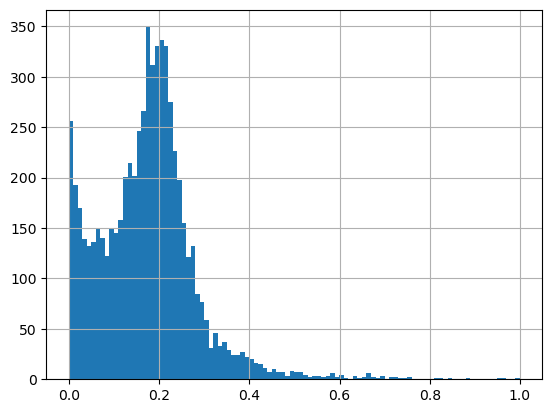

In [11]:
df.loc[df.mask_percentage!=0].mask_percentage.hist(bins=100)

In [12]:
val_locs = df.loc[df.is_val==True].location.unique()

In [13]:
val_locs

array(['6305_471', '6286_569', '6259_564', '6269_502', '6286_568',
       '6370_572', '6323_554', '6370_571', '6305_470', '6323_555',
       '6369_559', '6368_590', '6369_560', '6368_591', '6269_501'],
      dtype=object)

# Recreate dataloaders

In [23]:
from training import BinaryConverter

In [24]:
codes = [0,1]

In [25]:
sz = (500,500)
sz = (250,250)

In [26]:
bs=16

In [29]:
if task==1:
    
    from training import get_batch_tfms, get_dataloaders, get_cbs, BinaryConverter
    item_tfms=[BinaryConverter()] 
    batch_tfms = get_batch_tfms(normalize=Normalize.from_stats(*imagenet_stats), size=None)
    dls = get_dataloaders(df, x_name='image', y_name='mask', codes=codes, 
                          splitter=ColSplitter('is_val'), 
                          bs=bs, item_tfms=item_tfms, 
                          batch_tfms=batch_tfms)
if task==2: 
    from training import get_multiband_dataloaders, get_multiband_item_tfms, get_cbs
    dls = get_multiband_dataloaders(df, x_name='image_lidar', y_name='mask',
                      codes=codes,
                      splitter=ColSplitter('is_val'), bs=bs,
                      item_tfms=get_multiband_item_tfms(size=sz),
                      batch_tfms=Normalize())

In [27]:
models = [resnet34, resnet50, xresnet34, xresnet50]
model_idx = 0

In [28]:
model_name = str(models[model_idx]).split(' ')[1]
model_name

'resnet34'

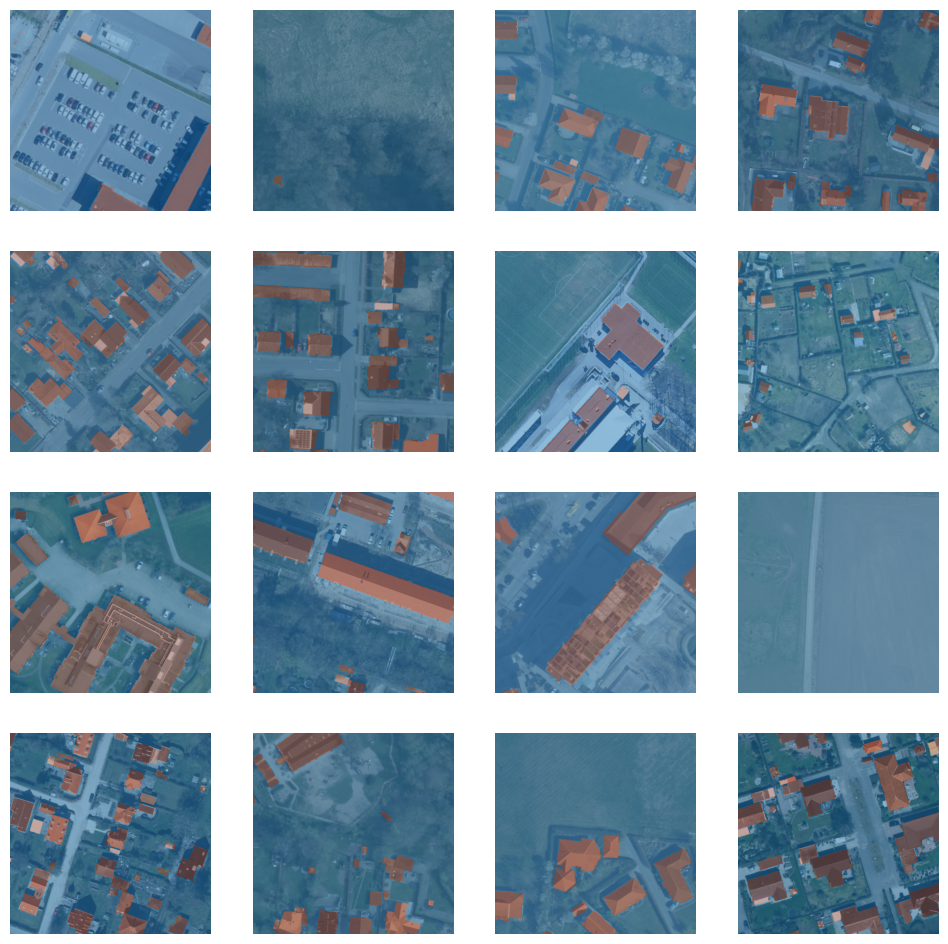

In [19]:
dls.show_batch(max_n=16)

# Load trained model

In [33]:
opt = ranger

In [34]:
metrics = [Dice, iou]

# Ensembling

In [35]:
from loss_functions import CombinedFocalTanimotoLoss
loss_func = CombinedFocalTanimotoLoss()
def get_learner(weights):
    learn = unet_learner(dls, models[model_idx], metrics=metrics, loss_func=loss_func,   
                     self_attention=True).to_fp16() 
    learn.load(weights)
    return learn

In [36]:
weights = [
    'MapAI-500_resnet34-2022-11-22',
    'MapAI-500_resnet34-2022-11-25-focalanimoto',
    'MapAI-500_resnet34-2022-11-28-focaltanimoto'
]

In [37]:
learners = [get_learner(w) for w in weights]

/home/ubuntu/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [125]:
learners

In [126]:
df.loc[df.is_val].head()

,image,lidar,mask,is_val,mask_percentage,is_building,location,image_lidar
7000,/home/ubuntu/data/mapai/data/validation/images/6305_471_68.tif,/home/ubuntu/data/mapai/data/validation/lidar/6305_471_68.tif,/home/ubuntu/data/mapai/data/validation/masks/6305_471_68.tif,True,0.010072,True,6305_471,/home/ubuntu/data/mapai/data/validation/images/6305_471_68.tif;/home/ubuntu/data/mapai/data/validation/lidar/6305_471_68.tif
7001,/home/ubuntu/data/mapai/data/validation/images/6286_569_17.tif,/home/ubuntu/data/mapai/data/validation/lidar/6286_569_17.tif,/home/ubuntu/data/mapai/data/validation/masks/6286_569_17.tif,True,0.000536,True,6286_569,/home/ubuntu/data/mapai/data/validation/images/6286_569_17.tif;/home/ubuntu/data/mapai/data/validation/lidar/6286_569_17.tif
7002,/home/ubuntu/data/mapai/data/validation/images/6305_471_0.tif,/home/ubuntu/data/mapai/data/validation/lidar/6305_471_0.tif,/home/ubuntu/data/mapai/data/validation/masks/6305_471_0.tif,True,0.002148,True,6305_471,/home/ubuntu/data/mapai/data/validation/images/6305_471_0.tif;/home/ubuntu/data/mapai/data/validation/lidar/6305_471_0.tif
7003,/home/ubuntu/data/mapai/data/validation/images/6259_564_71.tif,/home/ubuntu/data/mapai/data/validation/lidar/6259_564_71.tif,/home/ubuntu/data/mapai/data/validation/masks/6259_564_71.tif,True,0.210372,True,6259_564,/home/ubuntu/data/mapai/data/validation/images/6259_564_71.tif;/home/ubuntu/data/mapai/data/validation/lidar/6259_564_71.tif
7004,/home/ubuntu/data/mapai/data/validation/images/6269_502_60.tif,/home/ubuntu/data/mapai/data/validation/lidar/6269_502_60.tif,/home/ubuntu/data/mapai/data/validation/masks/6269_502_60.tif,True,0.155992,True,6269_502,/home/ubuntu/data/mapai/data/validation/images/6269_502_60.tif;/home/ubuntu/data/mapai/data/validation/lidar/6269_502_60.tif


In [151]:
from utils import compute_dice

Getting prediction from model #1/3 


Dice: 0.8122860020140987

Getting prediction from model #2/3 


Dice: 0.8114051822817302

Getting prediction from model #3/3 


Dice: 0.9098989690188884

Dice ensemble: 0.9128742670333662


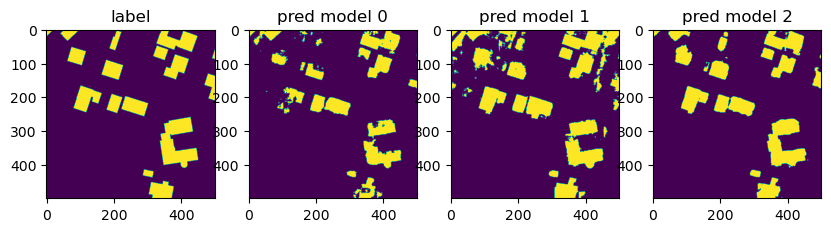

In [164]:
idx = 5
img_fn, label_fn = df.loc[df.is_val].iloc[idx]['image'], df.loc[df.is_val].iloc[idx]['mask']
img, label = PILImage.create(img_fn), np.uint8(TensorMask(PILImage.create(label_fn))[:,:,0])
all_probs, all_preds = [], []
i=1
for learn in learners:
    print(f"Getting prediction from model #{i}/{len(learners)} ")
    pred,_,probs = learn.predict(img)
    all_preds.append(pred)
    all_probs.append(probs)
    i+=1
    print(f"Dice: {compute_dice(pred, label)}\n")
all_probs = torch.stack(all_probs, dim=0)
mean = all_probs.mean(axis=0)
pred = torch.where(mean>0.5, 0, 1)[0,::]
prediction = np.uint8(pred)
print(f"Dice ensemble: {compute_dice(TensorMask(pred), label)}")
f,ax = plt.subplots(1,len(learners)+1, figsize=(10,5))
ax[0].imshow(label)
ax[0].set_title("label")
for i in range(len(learners)):
    ax[i+1].imshow(all_preds[i])
    ax[i+1].set_title(f"pred model {i}")
plt.show()

In [130]:
prediction.shape

(500, 500)

In [131]:
assert prediction.shape == label.shape, f"Prediction and label shape is not same, pls fix [{prediction.shape} - {label.shape}]"

In [97]:
compute_dice(TensorMask(prediction), label)

0.8746713938942215

In [98]:
compute_dice(TensorMask(all_preds[0]), label)

0.843763365706596

In [99]:
compute_dice(TensorMask(all_preds[1]), label)

0.8807906231937614

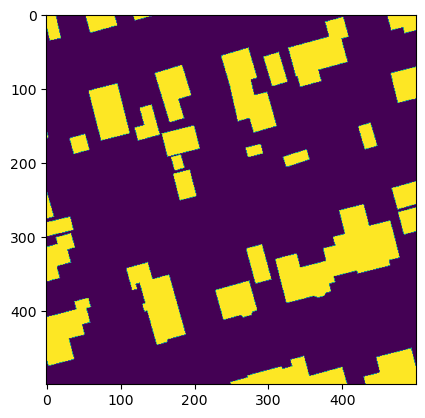

In [93]:
plt.imshow(label)

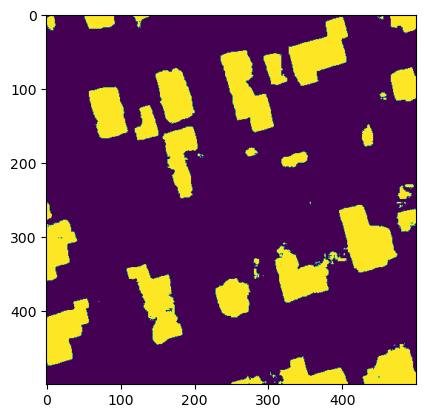

In [89]:
plt.imshow(prediction)

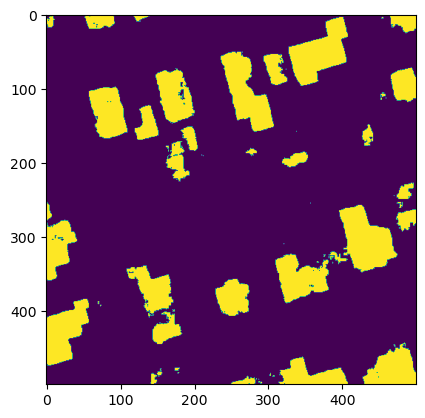

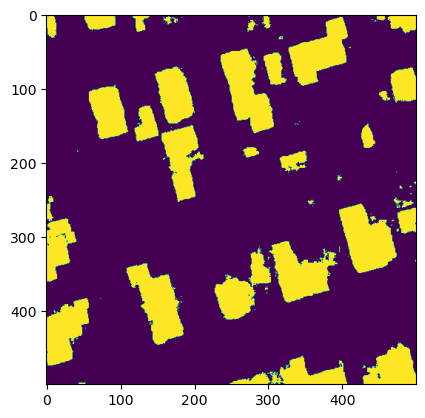

In [88]:
for pr in all_preds:
    plt.imshow(pr)
    plt.show()

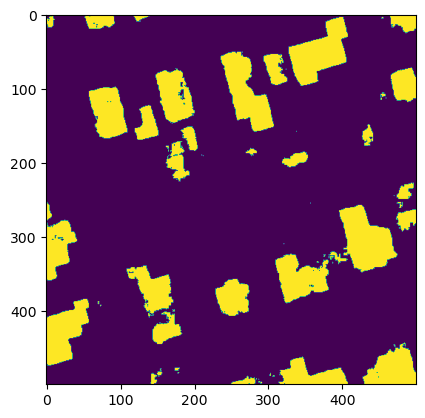

In [68]:
plt.imshow(prediction)

# Load pretrained weights

In [23]:
if task==1:
    from loss_functions import CombinedFocalTanimotoLoss
    loss_func = CombinedFocalTanimotoLoss()
    
    learn = unet_learner(dls, models[model_idx], metrics=metrics, loss_func=loss_func,   
                     self_attention=True).to_fp16() 
    
if task==2: 
    from loss_functions import multispectral_focal_tanimoto_loss
    loss_func = multispectral_focal_tanimoto_loss
    
    learn = unet_learner(dls, models[model_idx], n_in=4, n_out=2,
                         loss_func=loss_func,
                         pretrained=False, 
                         metrics=metrics,self_attention=True).to_fp16() 

/home/ubuntu/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
if task==1:
    save_fn = 'MapAI-500_resnet34-2022-11-22'
    save_fn = 'MapAI-500_resnet34-2022-11-25-focalanimoto'
if task==2:
    save_fn = f'MapAI-stage_1-500_resnet34_aerial-lidar-2022-11-29'
    save_fn = f'MapAI-stage_1-250_resnet34_aerial-lidar-2022-11-27-simple'

In [47]:
# Load pre-trained weights from Inria
learn.load(save_fn);

In [48]:
#learn.show_results(max_n=3)

# Predictions on single images

In [49]:
val_df = df.loc[df.is_val==True]

In [50]:
from utils import compute_dice

In [51]:
df.head()

,image,lidar,mask,is_val,mask_percentage,is_building,location,image_lidar
0,/home/ubuntu/data/mapai/data/train/images/6179_495_44.tif,/home/ubuntu/data/mapai/data/train/lidar/6179_495_44.tif,/home/ubuntu/data/mapai/data/train/masks/6179_495_44.tif,False,0.155224,True,6179_495,/home/ubuntu/data/mapai/data/train/images/6179_495_44.tif;/home/ubuntu/data/mapai/data/train/lidar/6179_495_44.tif
1,/home/ubuntu/data/mapai/data/train/images/6051_690_84.tif,/home/ubuntu/data/mapai/data/train/lidar/6051_690_84.tif,/home/ubuntu/data/mapai/data/train/masks/6051_690_84.tif,False,0.000000,False,6051_690,/home/ubuntu/data/mapai/data/train/images/6051_690_84.tif;/home/ubuntu/data/mapai/data/train/lidar/6051_690_84.tif
2,/home/ubuntu/data/mapai/data/train/images/6121_865_53.tif,/home/ubuntu/data/mapai/data/train/lidar/6121_865_53.tif,/home/ubuntu/data/mapai/data/train/masks/6121_865_53.tif,False,0.017824,True,6121_865,/home/ubuntu/data/mapai/data/train/images/6121_865_53.tif;/home/ubuntu/data/mapai/data/train/lidar/6121_865_53.tif
3,/home/ubuntu/data/mapai/data/train/images/6173_630_27.tif,/home/ubuntu/data/mapai/data/train/lidar/6173_630_27.tif,/home/ubuntu/data/mapai/data/train/masks/6173_630_27.tif,False,0.000000,False,6173_630,/home/ubuntu/data/mapai/data/train/images/6173_630_27.tif;/home/ubuntu/data/mapai/data/train/lidar/6173_630_27.tif
4,/home/ubuntu/data/mapai/data/train/images/6147_481_4.tif,/home/ubuntu/data/mapai/data/train/lidar/6147_481_4.tif,/home/ubuntu/data/mapai/data/train/masks/6147_481_4.tif,False,0.182664,True,6147_481,/home/ubuntu/data/mapai/data/train/images/6147_481_4.tif;/home/ubuntu/data/mapai/data/train/lidar/6147_481_4.tif


In [52]:
if task==2:
    from multispectral import custom_load_image,MImage

In [53]:
def get_imglidar_pred(df, idx, dice=False, show=True, savedir=None):
    
    imglidar_path = df.iloc[idx]['image_lidar']
    img_path = df.iloc[idx]['image']
    mask_path = df.iloc[idx]['mask']
    
    img_fn = Path(img_path).stem

    img_lidar = MImage(custom_load_image(imglidar_path))
    #img = PILImage.create(img_path)
    #lidar = PILImage.create(lidar_path)
    mask = TensorMask(PILImage.create(mask_path))[:,:,0]
    
    #img_lidar = torch.cat([Tensor(np.array(img)), Tensor(np.array(lidar))])
    
    pred,_,probs = learn.predict(img_lidar) #TTA?
    
    pred = torch.where(pred > 0.5, 0, 1)
    if dice:
        print(f"DICE: {compute_dice(mask, pred)}")
    
    if show:
        f, axs = plt.subplots(2,3, figsize=(8,10))
        axs[0][0].imshow(PILImage.create(img_path))
        axs[0][0].set_title(f"Original image")
        
        axs[0][1].imshow(np.array(pred)[0,::])
        axs[0][1].set_title(f"Predicted mask")
        
        axs[0][2].imshow(mask)
        axs[0][2].set_title(f"GT mask")
        
        axs[1][0].imshow(PILImage.create(img_path))
        axs[1][0].imshow(pred[0,::], alpha=0.4)
        axs[1][0].set_title(f"Prediction overlayed")
        
        axs[1][1].imshow(PILImage.create(img_path))
        axs[1][1].imshow(mask, alpha=0.4)
        axs[1][1].set_title(f"GT overlayed")
        plt.show()
        
    if savedir:
        pred_img = Image.fromarray(((pred.numpy()*255).astype('uint8')))
        pred_img.save(savedir/f'{img_fn}-mask.png')
        
    return pred

In [54]:
def get_img_pred(df, idx, dice=False, show=True, savedir=None):
    
    img_path = df.iloc[idx]['image']
    mask_path = df.iloc[idx]['mask']
    
    img_fn = Path(img_path).stem

    img = PILImage.create(img_path)
    mask = TensorMask(PILImage.create(mask_path))[:,:,0]
    
    #img_lidar = torch.cat([Tensor(np.array(img)), Tensor(np.array(lidar))])
    
    pred,_,probs = learn.predict(img) #TTA?
    
    if dice:
        print(f"DICE: {compute_dice(mask, pred)}")
    
    if show:
        f, axs = plt.subplots(2,3, figsize=(8,10))
        axs[0][0].imshow(PILImage.create(img_path))
        axs[0][0].set_title(f"Original image")
        
        axs[0][1].imshow(np.array(pred))
        axs[0][1].set_title(f"Predicted mask")
        
        axs[0][2].imshow(mask)
        axs[0][2].set_title(f"GT mask")
        
        axs[1][0].imshow(PILImage.create(img_path))
        axs[1][0].imshow(pred, alpha=0.4)
        axs[1][0].set_title(f"Prediction overlayed")
        
        axs[1][1].imshow(PILImage.create(img_path))
        axs[1][1].imshow(mask, alpha=0.4)
        axs[1][1].set_title(f"GT overlayed")
        plt.show()
        
    if savedir:
        pred_img = Image.fromarray(((pred.numpy()*255).astype('uint8')))
        pred_img.save(savedir/f'{img_fn}-mask.png')
        
    return pred

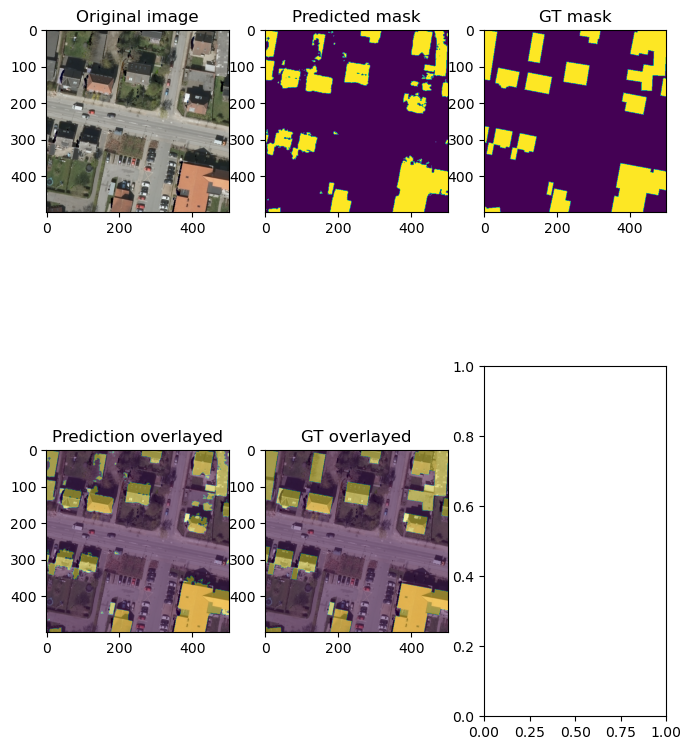

In [57]:
_ = get_img_pred(val_df, 7, show=True, dice=False, savedir=None)

In [58]:
MAPAI_VAL_PREDS

Path('/home/ubuntu/data/mapai/data/validation/predictions')

In [ ]:
# Save all masks
for i in range(len(val_df)):
    _ = get_img_pred(val_df, i, show=False, savedir=MAPAI_VAL_PREDS)

In [73]:
MAPAI_VAL_PREDS

Path('/home/ubuntu/data/mapai/data/validation/predictions')

## Insert in dataframe

In [78]:
val_df.head()

,image,lidar,mask,is_val,prediction,mask_percentage,is_building,location
0,/home/ubuntu/data/mapai/data/validation/images/6305_471_68.tif,/home/ubuntu/data/mapai/data/validation/lidar/6305_471_68.tif,/home/ubuntu/data/mapai/data/validation/masks/6305_471_68.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6305_471_68-mask.png,0.010072,True,6305_471
1,/home/ubuntu/data/mapai/data/validation/images/6286_569_17.tif,/home/ubuntu/data/mapai/data/validation/lidar/6286_569_17.tif,/home/ubuntu/data/mapai/data/validation/masks/6286_569_17.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_17-mask.png,0.000536,True,6286_569
2,/home/ubuntu/data/mapai/data/validation/images/6305_471_0.tif,/home/ubuntu/data/mapai/data/validation/lidar/6305_471_0.tif,/home/ubuntu/data/mapai/data/validation/masks/6305_471_0.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6305_471_0-mask.png,0.002148,True,6305_471
3,/home/ubuntu/data/mapai/data/validation/images/6259_564_71.tif,/home/ubuntu/data/mapai/data/validation/lidar/6259_564_71.tif,/home/ubuntu/data/mapai/data/validation/masks/6259_564_71.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6259_564_71-mask.png,0.210372,True,6259_564
4,/home/ubuntu/data/mapai/data/validation/images/6269_502_60.tif,/home/ubuntu/data/mapai/data/validation/lidar/6269_502_60.tif,/home/ubuntu/data/mapai/data/validation/masks/6269_502_60.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6269_502_60-mask.png,0.155992,True,6269_502


In [79]:
def get_predicted_png(fn):
    fn = Path(fn)
    folder = fn.parent
    png = fn.stem
    out_folder = Path(str(folder).replace("images", "predictions"))
    out_fn = f"{png}-mask.png"
    out_path = out_folder/out_fn
    return out_path

In [81]:
#val_df.insert(4, column='prediction', value=val_df['image'].apply(get_predicted_png))

In [83]:
#val_df.head()

In [39]:
val_df.to_csv('mapai_val_data_with_preds.csv', index=None)

# Stitch predictions back together

In [84]:
from utils import get_concat

In [85]:
val_df = pd.read_csv('mapai_val_data_with_preds.csv')

In [86]:
selected_location = '6286_569'

In [87]:
loc_df = val_df.loc[val_df.location==selected_location]

In [88]:
len(loc_df)

100

In [89]:
images_df = pd.DataFrame(loc_df.image.values.reshape(10,10))
images_df.head()

,0,1,2,3,4,5,6,7,8,9
0,/home/ubuntu/data/mapai/data/validation/images/6286_569_17.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_85.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_15.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_18.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_72.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_49.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_51.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_16.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_86.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_50.tif
1,/home/ubuntu/data/mapai/data/validation/images/6286_569_29.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_30.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_83.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_61.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_81.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_73.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_10.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_44.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_99.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_66.tif
2,/home/ubuntu/data/mapai/data/validation/images/6286_569_74.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_39.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_59.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_89.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_91.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_77.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_64.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_41.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_69.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_94.tif
3,/home/ubuntu/data/mapai/data/validation/images/6286_569_38.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_45.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_36.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_57.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_98.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_78.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_27.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_55.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_7.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_34.tif
4,/home/ubuntu/data/mapai/data/validation/images/6286_569_20.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_8.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_35.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_58.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_90.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_0.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_75.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_92.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_23.tif,/home/ubuntu/data/mapai/data/validation/images/6286_569_56.tif


In [90]:
predictions_df = pd.DataFrame(loc_df.prediction.values.reshape(10,10))
predictions_df.head()

,0,1,2,3,4,5,6,7,8,9
0,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_17-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_85-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_15-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_18-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_72-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_49-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_51-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_16-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_86-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_50-mask.png
1,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_29-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_30-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_83-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_61-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_81-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_73-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_10-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_44-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_99-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_66-mask.png
2,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_74-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_39-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_59-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_89-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_91-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_77-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_64-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_41-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_69-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_94-mask.png
3,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_38-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_45-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_36-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_57-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_98-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_78-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_27-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_55-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_7-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_34-mask.png
4,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_20-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_8-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_35-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_58-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_90-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_0-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_75-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_92-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_23-mask.png,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_56-mask.png


In [91]:
get_concat(images_df, '6286_569.jpg')

In [92]:
get_concat(predictions_df, '6305_471_pred.jpg')

In [110]:
def create_animation(location):
    # Create stitched-together original image
    images_df = pd.DataFrame(val_df.loc[val_df.location==location].image.values.reshape(10,10))
    get_concat(images_df, f'{location}.png')
    
    
    # Create stitched predicted masks:
    prediction_df = pd.DataFrame(val_df.loc[val_df.location==location].prediction.values.reshape(10,10))
    get_concat(prediction_df, f'{location}-predicted_mask.png')
    
    
    # Create multiple images with mask pasted in
    
    new_df = images_df.copy()
    for i in range(100):
        img_to_replace = images_df.to_numpy().flatten()[i]
        mask_to_insert = img_to_replace.replace(".png", "-mask.png").replace('images','predictions').replace('predictions', 'predictions/val')
        new_df = new_df.replace(img_to_replace,mask_to_insert)
        i+1
        get_concat(new_df, f'{location}_pred_{i}.jpg')
        
    # Create GIF animation
    fn_pattern = f'{location}_pred_*.jpg'
    gif_fn = f'{location}_preds.gif'
    !convert -resize 800x800 -delay 20 -loop 0 `ls -v1 $fn_pattern` $gif_fn

## Compute building footprint

In [103]:
from utils import get_building_percentage

In [106]:
val_df['pred_mask_percentage'] = val_df['prediction'].apply(get_building_percentage)

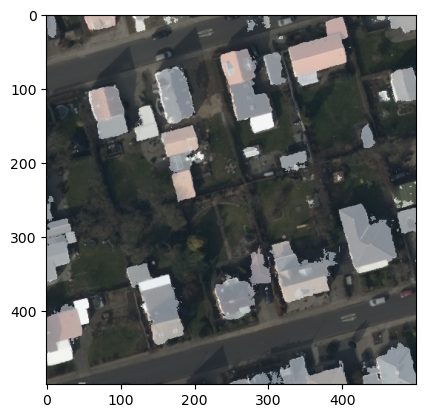

In [119]:
plt.imshow(PILImage.create('/home/ubuntu/data/mapai/data/validation/images/6259_564_71.tif'))

plt.imshow(PILImage.create('/home/ubuntu/data/mapai/data/validation/predictions/6259_564_71-mask.png'), alpha=0.4)

In [152]:
def check_preds(idx):
    img = PILImage.create(val_df.iloc[idx]['image'])
    mask = np.array(PILImage.create(val_df.iloc[idx]['mask']))
    mask = np.where(mask>0, 1, 0)
    pred = PILImage.create(val_df.iloc[idx]['prediction'])
    mask_perc = val_df.iloc[0].mask_percentage
    
    print(np.unique(mask))
    print(np.sum(mask))
    print(val_df.iloc[idx].image)
    print(mask_perc)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4)
    plt.show()
    plt.imshow(img)
    plt.imshow(pred, alpha=0.4)
    plt.show()

[0 1]
165438
/home/ubuntu/data/mapai/data/validation/images/6323_554_52.tif
0.010072


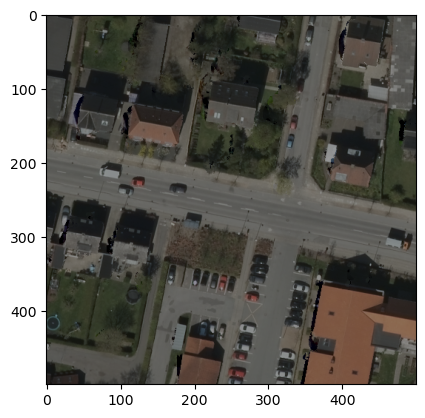

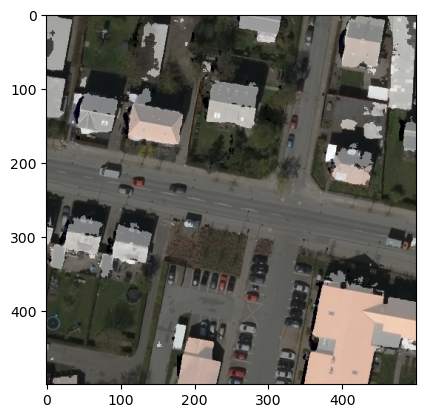

In [153]:
check_preds(7)

In [107]:
val_df.head()

,image,lidar,mask,is_val,prediction,mask_percentage,is_building,location,pred_mask_percentage
0,/home/ubuntu/data/mapai/data/validation/images/6305_471_68.tif,/home/ubuntu/data/mapai/data/validation/lidar/6305_471_68.tif,/home/ubuntu/data/mapai/data/validation/masks/6305_471_68.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6305_471_68-mask.png,0.010072,True,6305_471,0.24174
1,/home/ubuntu/data/mapai/data/validation/images/6286_569_17.tif,/home/ubuntu/data/mapai/data/validation/lidar/6286_569_17.tif,/home/ubuntu/data/mapai/data/validation/masks/6286_569_17.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6286_569_17-mask.png,0.000536,True,6286_569,0.13260
2,/home/ubuntu/data/mapai/data/validation/images/6305_471_0.tif,/home/ubuntu/data/mapai/data/validation/lidar/6305_471_0.tif,/home/ubuntu/data/mapai/data/validation/masks/6305_471_0.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6305_471_0-mask.png,0.002148,True,6305_471,0.71094
3,/home/ubuntu/data/mapai/data/validation/images/6259_564_71.tif,/home/ubuntu/data/mapai/data/validation/lidar/6259_564_71.tif,/home/ubuntu/data/mapai/data/validation/masks/6259_564_71.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6259_564_71-mask.png,0.210372,True,6259_564,54.00288
4,/home/ubuntu/data/mapai/data/validation/images/6269_502_60.tif,/home/ubuntu/data/mapai/data/validation/lidar/6269_502_60.tif,/home/ubuntu/data/mapai/data/validation/masks/6269_502_60.tif,True,/home/ubuntu/data/mapai/data/validation/predictions/6269_502_60-mask.png,0.155992,True,6269_502,38.80488


In [99]:
def get_gt_relative_building_footprint(location):
    df_loc = val_df.loc[val_df.location==location]
    return df_loc.mask_percentage.sum() 

In [102]:
get_gt_relative_building_footprint('6305_471')

8.290296000000001

In [ ]:
def get_pred_relative_building_footprint(location):
    